In [ ]:
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, LongT5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch
import re
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AdamW
from transformers import AutoTokenizer, LongT5Model

tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
class llm_regress(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {'input_ids': self.encodings['input_ids'][idx], 'attention_mask': self.encodings['attention_mask'][idx], 'labels': self.labels['input_ids'][idx]}

    def __len__(self):
        return len(self.labels['input_ids'])

In [ ]:
def number_to_exponential(number):
    return f"{number:.3e}"

In [ ]:
def number_to_token(value):
  if value >= 0:
    sign = "(+)"
  else:
    sign = "(-)"

  exponential = number_to_exponential(value)
  pattern = r"^[\+\-]?(\d)\.(\d)(\d)(\d)e([\+\-]{1}\d\d)$"

  match = re.search(pattern, exponential)
  if match.groups():
    groups_list = list(match.groups())
    tokens = ['('+i+')' for i in groups_list]
    tokens.insert(0, sign)
    exponential = tokens.pop()
    exponential = '(' + exponential[1] + ')' + '(' + exponential[2:4] + ')'
    tokens.append(exponential)
    tokens = "".join(tokens)
  else:
    print(value)
    print(exponential)
  return tokens

Data Source : https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/dataset/house-prices-advanced-regression-techniques/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
important_features = [
    'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
    'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
    'ExterQual', 'Foundation', 'TotalBsmtSF', 'GrLivArea', 'GarageCars'
]

df = df.dropna(axis=1)
df = df.drop('Id', axis=1)
#drop the column with NaN value
df = df.drop(["EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea",	"MiscVal",	"MoSold"], axis=1)
target = df['SalePrice']
target = np.log(target)
df = df.drop(columns=['SalePrice'])
df = df[important_features]
x = [str(dict(df.loc[i, :])) for i in range(df.shape[0])]
target_texts = [str(number_to_token(target[i])) for i in range(df.shape[0])]
# add the task prefix to input sequence
input_texts = ["{objective:regression, type:housing_price} : " + sentence for sentence in x]

In [ ]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'ExterQual', 'Foundation', 'TotalBsmtSF', 'GrLivArea', 'GarageCars'],
      dtype='object')

In [ ]:
input_texts[0:5]

["{objective:regression, type:housing_price} : {'MSSubClass': 60, 'MSZoning': 'RL', 'LotArea': 8450, 'Street': 'Pave', 'LotShape': 'Reg', 'LandContour': 'Lvl', 'Utilities': 'AllPub', 'LotConfig': 'Inside', 'LandSlope': 'Gtl', 'Neighborhood': 'CollgCr', 'Condition1': 'Norm', 'BldgType': '1Fam', 'HouseStyle': '2Story', 'OverallQual': 7, 'OverallCond': 5, 'YearBuilt': 2003, 'YearRemodAdd': 2003, 'RoofStyle': 'Gable', 'Exterior1st': 'VinylSd', 'Exterior2nd': 'VinylSd', 'ExterQual': 'Gd', 'Foundation': 'PConc', 'TotalBsmtSF': 856, 'GrLivArea': 1710, 'GarageCars': 2}",
 "{objective:regression, type:housing_price} : {'MSSubClass': 20, 'MSZoning': 'RL', 'LotArea': 9600, 'Street': 'Pave', 'LotShape': 'Reg', 'LandContour': 'Lvl', 'Utilities': 'AllPub', 'LotConfig': 'FR2', 'LandSlope': 'Gtl', 'Neighborhood': 'Veenker', 'Condition1': 'Feedr', 'BldgType': '1Fam', 'HouseStyle': '1Story', 'OverallQual': 6, 'OverallCond': 8, 'YearBuilt': 1976, 'YearRemodAdd': 1976, 'RoofStyle': 'Gable', 'Exterior1st':

In [ ]:
target_texts[0:5]

['(+)(1)(2)(2)(5)(+)(01)',
 '(+)(1)(2)(1)(1)(+)(01)',
 '(+)(1)(2)(3)(2)(+)(01)',
 '(+)(1)(1)(8)(5)(+)(01)',
 '(+)(1)(2)(4)(3)(+)(01)']

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

setup data

In [ ]:
BATCH_SIZE = 8
SEED = 41


*   Use 8 batch size due to the memory limitation.
*   split data into train, eval, test with 90%:5%:5%



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_texts, target_texts, test_size=0.10, shuffle=True, random_state=SEED)
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, test_size=0.50, shuffle=True, random_state=SEED)

In [ ]:
target_encodings_train

In [ ]:
input_encodings_train = tokenizer(X_train, padding=True, truncation=False, return_tensors="pt")
target_encodings_train = tokenizer(y_train, padding=True, truncation=False, return_tensors="pt")
dataset_train = llm_regress(input_encodings_train, target_encodings_train)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
input_encodings_eval = tokenizer(X_eval, padding=True, truncation=False, return_tensors="pt")
target_encodings_eval = tokenizer(y_eval, padding=True, truncation=False, return_tensors="pt")
dataset_eval = llm_regress(input_encodings_eval, target_encodings_eval)
loader_eval = DataLoader(dataset_eval, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
input_encodings_test = tokenizer(X_test, padding=True, truncation=False, return_tensors="pt")
target_encodings_test = tokenizer(y_test, padding=True, truncation=False, return_tensors="pt")
dataset_test = llm_regress(input_encodings_test, target_encodings_test)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Training Iteration with loss plot

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0 | Train Loss: 1.43208, Eval Loss: 0.44911
Epoch: 1 | Train Loss: 0.50850, Eval Loss: 0.40057
Epoch: 2 | Train Loss: 0.44071, Eval Loss: 0.38659
Epoch: 3 | Train Loss: 0.40341, Eval Loss: 0.37300
Epoch: 4 | Train Loss: 0.38903, Eval Loss: 0.37227
Epoch: 5 | Train Loss: 0.37945, Eval Loss: 0.37411
Epoch: 6 | Train Loss: 0.36911, Eval Loss: 0.36684
Epoch: 7 | Train Loss: 0.36548, Eval Loss: 0.36027
Epoch: 8 | Train Loss: 0.35917, Eval Loss: 0.35739
Epoch: 9 | Train Loss: 0.34807, Eval Loss: 0.34737
Epoch: 10 | Train Loss: 0.34029, Eval Loss: 0.34644
Epoch: 11 | Train Loss: 0.33756, Eval Loss: 0.34132
Epoch: 12 | Train Loss: 0.33320, Eval Loss: 0.34468
Epoch: 13 | Train Loss: 0.33133, Eval Loss: 0.34040
Epoch: 14 | Train Loss: 0.33160, Eval Loss: 0.33687
Epoch: 15 | Train Loss: 0.32745, Eval Loss: 0.33114
Epoch: 16 | Train Loss: 0.32342, Eval Loss: 0.33072
Epoch: 17 | Train Loss: 0.32003, Eval Loss: 0.33262
Epoch: 18 | Train Loss: 0.32089, Eval Loss: 0.32240
Epoch: 19 | Train Loss

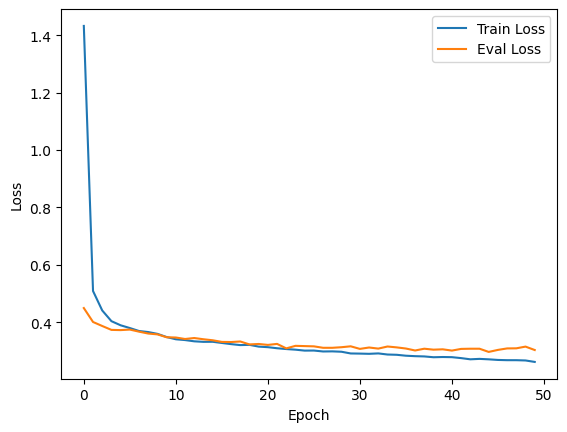

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
# num_epochs = 100
num_epochs = 50
model.to(device)

train_loss_list = []
eval_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_eval_loss = 0
    num_train_batches = 0
    num_eval_batches = 0

    # Training phase
    for batch in loader_train:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        num_train_batches += 1
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / num_train_batches
    train_loss_list.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        for batch in loader_eval:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_eval_loss += loss.item()
            num_eval_batches += 1

    avg_eval_loss = total_eval_loss / num_eval_batches
    eval_loss_list.append(avg_eval_loss)

    print(f"Epoch: {epoch} | Train Loss: {avg_train_loss:.5f}, Eval Loss: {avg_eval_loss:.5f}")

# Plotting outside the loop
plt.plot(train_loss_list, label='Train Loss')
plt.plot(eval_loss_list, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate how model perform for test data

In [ ]:
total_eval_loss = 0
num_eval_batches = 0
outputs = []
model.eval()
with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        do_sample=False,  # disable sampling to test if batching affects output
    )
        output_sequences = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)
        outputs.extend(output_sequences)
        print(output_sequences)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['(+)(1)(1)(8)(5)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(2)(1)(9)(+)(01)', '(+)(1)(2)(2)(8)(+)(01)', '(+)(1)(1)(3)(3)(+)(01)', '(+)(1)(1)(7)(8)(+)(01)', '(+)(1)(2)(3)(0)(+)(01)']
['(+)(1)(2)(6)(2)(+)(01)', '(+)(1)(1)(9)(2)(+)(01)', '(+)(1)(2)(9)(9)(+)(01)', '(+)(1)(1)(9)(0)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(2)(3)(3)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)']
['(+)(1)(2)(6)(9)(+)(01)', '(+)(1)(2)(2)(7)(+)(01)', '(+)(1)(1)(3)(3)(+)(01)', '(+)(1)(2)(3)(3)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(2)(1)(0)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)']
['(+)(1)(2)(3)(7)(+)(01)', '(+)(1)(2)(0)(0)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(2)(1)(0)(+)(01)', '(+)(1)(2)(0)(0)(+)(01)', '(+)(1)(2)(5)(2)(+)(01)', '(+)(1)(1)(5)(5)(+)(01)']
['(+)(1)(1)(8)(8)(+)(01)', '(+)(1)(1)(6)(5)(+)(01)', '(+)(1)(2)(2)(1)(+)(01)', '(+)(1)(2)(8)(9)(+)(01)', '(+)(1)(2)(1)(0)(+)(01)', '(+)(1)(1)(8)(8)(+)(01)', '(+)(1)

In [ ]:
def token_to_float(value):
  pattern = r"^\(([\+\-]{1})\)\(([0-9]{1})\)\(([0-9]{1})\)\(([0-9]{1})\)\(([0-9]{1})\)\(([\+\-]{1})\)\(([0-9]{2})\)$"
  match = re.search(pattern, value)
  empty_string = ""
  if match.groups():
    try:
      groups_list = list(match.groups())
      sign = groups_list[0]
      digit_list = groups_list[1:5]
      power_sign = groups_list[5]
      num_power = groups_list[6]

      if sign == "+":
        sign = ""
      empty_string = sign + empty_string

      empty_string += digit_list[0]
      empty_string += "."
      empty_string += digit_list[1]
      empty_string += digit_list[2]
      empty_string += digit_list[3]

      empty_string += "e"
      empty_string += power_sign
      empty_string += num_power
      empty_string = float(empty_string)
      return empty_string
    except:
      return None
  else:
    return None

In [ ]:
predicted_values = [token_to_float(i) for i in outputs]
true_values = [token_to_float(i) for i in y_test]

(array([ 3.,  1.,  7., 19., 23.,  7.,  6.,  4.,  1.,  2.]),
 array([11.3  , 11.469, 11.638, 11.807, 11.976, 12.145, 12.314, 12.483,
        12.652, 12.821, 12.99 ]),
 <BarContainer object of 10 artists>)

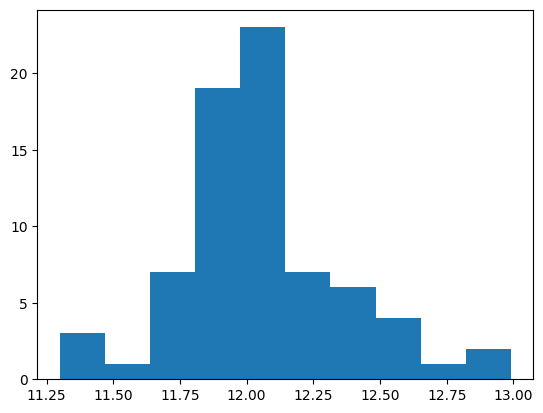

In [ ]:
plt.hist(predicted_values)

(array([ 1.,  0.,  0.,  4., 25., 20., 13.,  7.,  2.,  1.]),
 array([10.86 , 11.075, 11.29 , 11.505, 11.72 , 11.935, 12.15 , 12.365,
        12.58 , 12.795, 13.01 ]),
 <BarContainer object of 10 artists>)

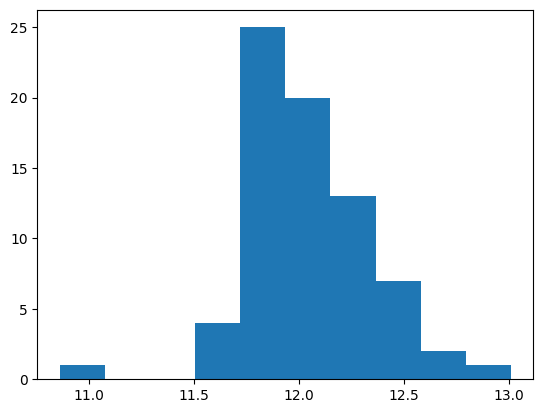

In [ ]:
plt.hist(true_values)

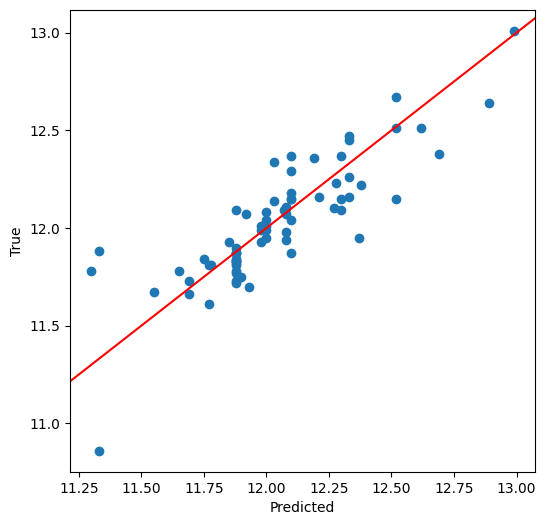

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(predicted_values, true_values)
plt.axline((12, 12), slope=1, color='red')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

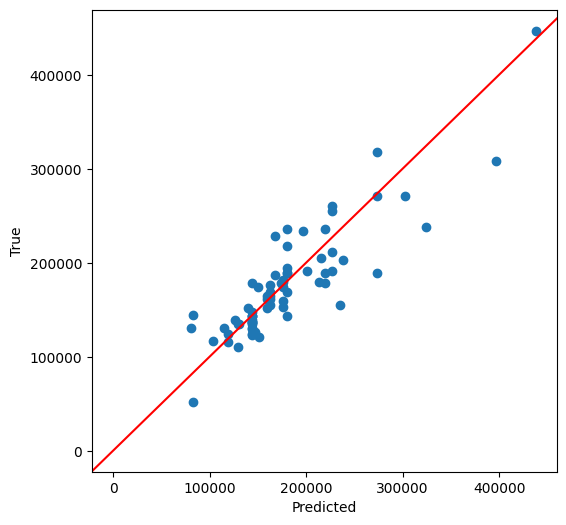

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(np.exp(predicted_values), np.exp(true_values))
plt.axline((12, 12), slope=1, color='red')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
mse = np.sum((np.array(predicted_values) - np.array(true_values)) ** 2) / len(predicted_values)
print(f"MSE for test data is : {mse}" )
print(f"RMSE for test data is : {np.sqrt(mse)}")

MSE for test data is : 0.029124657534246576
RMSE for test data is : 0.1706594783018118


Create the inference for public test data and submit to kaggle competition "House Prices - Advanced Regression Techniques"

In [ ]:
used_columns = list(df.columns)

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/NLP/dataset/house-prices-advanced-regression-techniques/test.csv")
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/NLP/dataset/house-prices-advanced-regression-techniques/sample_submission.csv")
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [ ]:
def create_target_and_input(df):
  df = df[used_columns]
  x = [str(dict(df.loc[i, :])) for i in range(df.shape[0])]
  # add the task prefix to input sequence
  input_texts = ["{objective:regression, type:housing_price} : " + sentence for sentence in x]
  dummy_target = ["0"] * len(input_texts)
  return input_texts, dummy_target

In [ ]:
X_test, y_dummy = create_target_and_input(test_df)

In [ ]:
X_test[0]

"{objective:regression, type:housing_price} : {'MSSubClass': 20, 'MSZoning': 'RH', 'LotArea': 11622, 'Street': 'Pave', 'LotShape': 'Reg', 'LandContour': 'Lvl', 'Utilities': 'AllPub', 'LotConfig': 'Inside', 'LandSlope': 'Gtl', 'Neighborhood': 'NAmes', 'Condition1': 'Feedr', 'BldgType': '1Fam', 'HouseStyle': '1Story', 'OverallQual': 5, 'OverallCond': 6, 'YearBuilt': 1961, 'YearRemodAdd': 1961, 'RoofStyle': 'Gable', 'Exterior1st': 'VinylSd', 'Exterior2nd': 'VinylSd', 'ExterQual': 'TA', 'Foundation': 'CBlock', 'TotalBsmtSF': 882.0, 'GrLivArea': 896, 'GarageCars': 1.0}"

In [ ]:
y_dummy[0]

'0'

In [ ]:
input_encodings_test = tokenizer(X_test, padding=True, truncation=False, return_tensors="pt")
target_encodings_test = tokenizer(y_dummy, padding=True, truncation=False, return_tensors="pt")
dataset_test = llm_regress(input_encodings_test, target_encodings_test)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
outputs = []
model.eval()
with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        do_sample=False,
    )
        output_sequences = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)
        outputs.extend(output_sequences)
print(outputs)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['(+)(1)(1)(6)(8)(+)(01)', '(+)(1)(1)(9)(8)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(2)(2)(1)(+)(01)', '(+)(1)(2)(1)(0)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(2)(0)(0)(+)(01)', '(+)(1)(1)(7)(0)(+)(01)', '(+)(1)(2)(2)(2)(+)(01)', '(+)(1)(1)(5)(1)(+)(01)', '(+)(1)(1)(5)(1)(+)(01)', '(+)(1)(1)(9)(8)(+)(01)', '(+)(1)(1)(7)(8)(+)(01)', '(+)(1)(2)(8)(8)(+)(01)', '(+)(1)(2)(8)(8)(+)(01)', '(+)(1)(2)(8)(8)(+)(01)', '(+)(1)(2)(8)(8)(+)(01)', '(+)(1)(2)(9)(9)(+)(01)', '(+)(1)(2)(8)(8)(+)(01)', '(+)(1)(2)(3)(3)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(2)(0)(7)(+)(01)', '(+)(1)(2)(1)(0)(+)(01)', '(+)(1)(2)(9)(2)(+)(01)', '(+)(1)(2)(6)(9)(+)(01)', '(+)(1)(2)(2)(8)(+)(01)', '(+)(1)(2)(0)(8)(+)(01)', '(+)(1)(2)(2)(7)(+)(01)', '(+)(1)(1)(2)(9)(+)(01)', '(+)(1)(2)(1)(0)(+)(01)', '(+)(1)(2)(5)(9)(+)(01)', '(+)(1)(2)(6)(9)(+)(01)', '(+)(1)(2)(1)(0)(+)(01)', '(+)(1)(1)(9)(8)(+)(01)', '(+)(1)(1)(9)(8)(+)(01)', '(+)(1)(1)(

In [ ]:
predicted = [token_to_float(i) for i in outputs]

In [ ]:
np.exp(np.array(predicted))

array([118184.23506804, 159532.03062323, 176310.16074634, ...,
       150241.60841163, 133252.35294553, 219695.98867214])

In [ ]:
sample_submission['SalePrice'] = np.exp(np.array(predicted))

In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/NLP/dataset/house-prices-advanced-regression-techniques/submission.csv', index=False)